In [115]:
import pandas as pd 
import numpy as np
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ConstraintBased.PC import pc 
from causallearn.utils.cit import chisq
from causallearn.utils.cit import gsq
from matplotlib import pyplot as plt
from causallearn.utils.GraphUtils import GraphUtils

In [ ]:
#read csv - on first run 
slurm_path = "/home/cc/CS520_Project/slurm-log.csv"
df = pd.read_csv(slurm_path)
#second run saved csv so you can avoid preproc
slurm_buff_path = "/home/cc/CS520_Project/slurm_log_buff.csv"
df = pd.read_csv(slurm_path)


In [ ]:
#Preprocessing
#Discretizing continuous variables 
#Picking columns 
#deriving new columns - system load, runtime, node hours, user job frequency,
#Handling missing values
#try different configurations of FCI

#calculate system load as count of jobs running at a given time

def calculate_system_load(df):
    for index, row in df.iterrows():
        start_time = row['time_start']
        end_time = row['time_end']
        system_load = df[(df['time_start'] <= end_time) & (df['time_end'] >= start_time)].shape[0]
        df.at[index, 'system_load'] = system_load
    return df
df = calculate_system_load(df)

In [ ]:
#preprocess
df_grouped = df.groupby('id_user').agg({'id_job': 'count'}).reset_index().rename(columns={'id_job': 'user_job_frequency'})
df = pd.merge(df, df_grouped, on='id_user', how='left') 
df['runtime'] = ( df['time_end']- df['time_start'])/3600
df['node_hours'] = df['nodes_alloc'] * df['runtime']
#if exit_code is not 0 add status column as 1 and 0 if exit code is 0
df['status'] = df['exit_code'] 
df['status'] = (df['status'] != 0).astype(int)
#df = calculate_system_load(df)


In [120]:
#save csv with new cols
#df.to_csv('slurm_log_buff.csv')

In [ ]:
#START EXPERIMENTS FROM HERE INSTEAD OF BEGINNING IF NEW COLS HAVE BEEN ADDED
slurm_buff_path = "/home/cc/CS520_Project/slurm_log_buff.csv"
df = pd.read_csv(slurm_path)

In [50]:
select_cols = ['nodes_alloc', 
'cpus_req', 
'mem_req', 
'partition',
 #'priority',
 #'timelimit', 
 #'job_type', 
 'runtime',
 'system_load',
 'node_hours',
 'user_job_frequency',
 'status'] 
df_res = df[select_cols]

In [51]:
#categorical vars encode
#df_res['job_type'] = df_res['job_type'].astype('category')
#df_res['job_type'] = df_res['job_type'].cat.codes
df_res['partition'] = df_res['partition'].astype('category')
df_res['partition'] = df_res['partition'].cat.codes
#df_res['priority'] = df_res['priority'].astype('category')
#df_res['priority'] = df_res['priority'].cat.codes


/tmp/ipykernel_6593/1053097455.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['partition'] = df_res['partition'].astype('category')
/tmp/ipykernel_6593/1053097455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['partition'] = df_res['partition'].cat.codes


,nodes_alloc,cpus_req,mem_req,partition,runtime,system_load,node_hours,user_job_frequency,status
0,1,20,9223372036854784308,2,0.085556,1.0,0.085556,7972,0
1,1,20,9223372036854784308,2,0.110278,2.0,0.110278,7972,0
2,1,20,9223372036854784308,2,0.090833,2.0,0.090833,7972,0
3,1,1,9223372036854784308,2,1.069722,155.0,1.069722,479,1
4,1,20,9223372036854784308,2,0.085278,3.0,0.085278,7972,0
...,...,...,...,...,...,...,...,...,...
395909,1,1,51200,4,0.106111,26.0,0.106111,375,0
395910,1,1,51200,4,0.170833,24.0,0.170833,375,0
395911,1,1,51200,4,0.118056,23.0,0.118056,375,0
395912,1,1,51200,4,0.134444,23.0,0.134444,375,0


In [ ]:
#discretize cat vars
#q value can be changed to fit data better, need to analyze this split a bit more 
df_res['runtime'] = pd.qcut(df_res['runtime'],q=3,labels = False, duplicates = 'drop')
#df_res['timelimit'] = pd.qcut(df_res['timelimit'],q=4,labels = False, duplicates = 'drop')
df_res['node_hours'] = pd.qcut(df_res['node_hours'],q=3,labels = False, duplicates = 'drop')
df_res['mem_req'] = pd.qcut(df_res['mem_req'],q=3,labels = False, duplicates = 'drop')
df_res['system_load'] = pd.qcut(df_res['system_load'],q=3,labels = False, duplicates = 'drop')
df_res['user_job_frequency'] = pd.qcut(df_res['user_job_frequency'],q=3,labels = False, duplicates = 'drop')

/tmp/ipykernel_6593/2239607784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['runtime'] = pd.qcut(df_res['runtime'],q=3,labels = False, duplicates = 'drop')
/tmp/ipykernel_6593/2239607784.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['node_hours'] = pd.qcut(df_res['node_hours'],q=3,labels = False, duplicates = 'drop')
/tmp/ipykernel_6593/2239607784.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [ ]:
consensus_subsample(data,algo='FCI',ci_test = gsq, alpha = 0.05, subsample_size = 100000, n_subsamples = 20 , edge_freq_thres= 0.5):
    rng = np.random.default_rng(0)
    graphs = []
    for i in range(n_subsamples):
        idx = rng.choice(data.shape[0], size=subsample_size, replace=False)
        data_sub = arr[idx, :]
        if algo.upper() == 'FCI' :
            g, _ = fci(data_sub,ci_test,alpha = alpha)
        else:
            g = pc(data_sub,ci_test, alpha = alpha)
        graphs.append(g)

    edge_counts = Counter()
    for g in graphs:
        for e in g.G.graph:
            edge_counts()
            


In [ ]:
#convert to numpy arr and choose subsample
sam_size = 100000
arr = df_res.to_numpy()
rng = np.random.default_rng(0)
idx = rng.choice(arr.shape[0], size=sam_size, replace=False)
data_sub = arr[idx, :]

In [129]:
#FCI TEst
CI_test = gsq # or chitest choose one these work for discrete data
a = 0.01 #strictness of ci tests basically, lower allows for more directions being revealed
g, edges = fci(data_sub,CI_test, alpha=a)

Depth=0, working on node 8: 100%|██████████| 9/9 [00:00<00:00, 165.72it/s]


X4 --> X1
X1 --> X5
X8 --> X1
X3 --> X4
X5 --> X3
X8 --> X4


2
-1
-1
2
-1
-1
2
2
2
2
2
2
2
-1
-1
2
-1
-1
1
2
-1
-1
1
2
-1
1
2
2
2
2
1


In [ ]:
#visualize
output_file = 'result_fci.jpg'
pdy = GraphUtils.to_pydot(g)
pdy.write_jpg(output_file)

In [125]:
#PC Algo
#same tweaks as fci can choose alpha and ci test wo
cg = pc(data_sub,alpha = a, indep_test = CI_test)

Depth=0, working on node 0:  11%|█         | 1/9 [00:00<00:00, 997.22it/s]

Depth=7, working on node 8: 100%|██████████| 9/9 [00:00<00:00, 44.71it/s]  


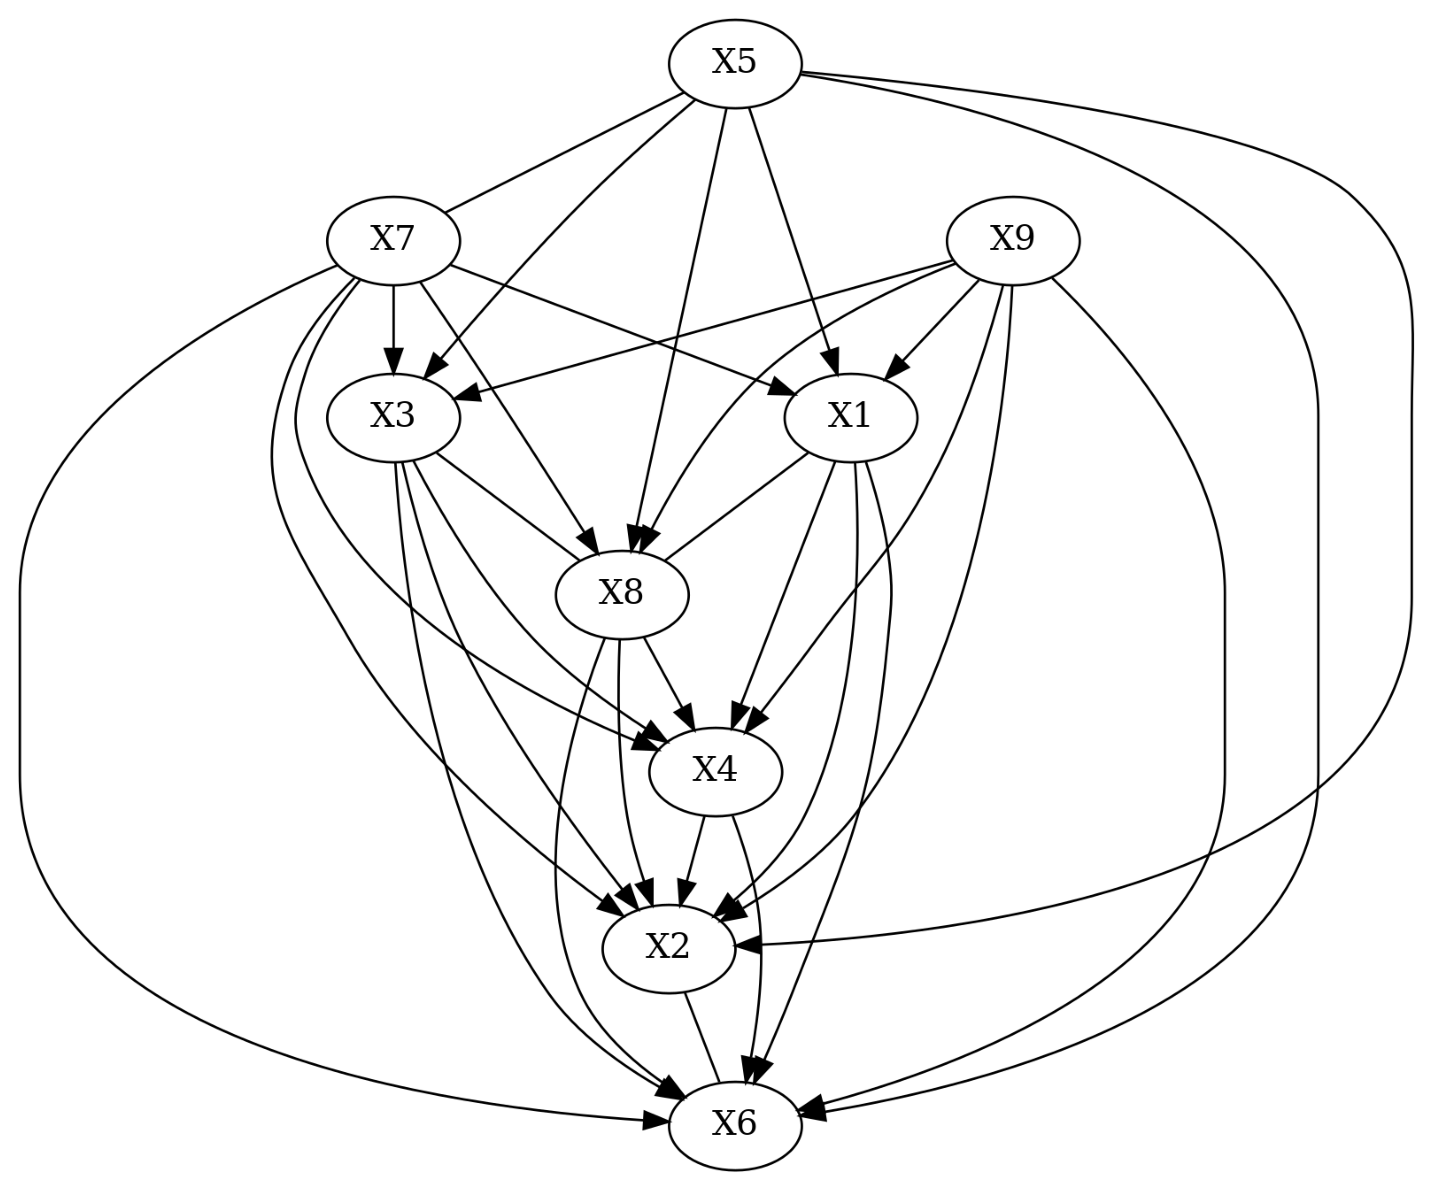

In [128]:
#visualize and save
cg.draw_pydot_graph()
pyd = GraphUtils.to_pydot(cg.G)
output_file = 'result_pc.png'
pyd.write_png(output_file)

In [ ]:
#Since we are using subsamples maybe run each algo x number of times to see if output is stable or not
# Note down differences and similarities in the data 

nodes_alloc
nodes_alloc
cpus_req
cpus_req
mem_req
mem_req
partition
partition
runtime
runtime
system_load
system_load
node_hours
node_hours
user_job_frequency
user_job_frequency
status
status


In [ ]:
#mapping of nodes to actual names
col_mapping = {f"x{i+1}": col for i, col in enumerate(df_res.columns)}
print(col_mapping)

{'x1': 'nodes_alloc', 'x2': 'cpus_req', 'x3': 'mem_req', 'x4': 'partition', 'x5': 'runtime', 'x6': 'system_load', 'x7': 'node_hours', 'x8': 'user_job_frequency', 'x9': 'status'}
